# Import Package
utils.py is from the alibaba dataset: https://github.com/alibaba/clusterdata/blob/master/cluster-trace-gpu-v2020

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os.path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import category_encoders as ce
from ncps.torch import CfC
from ncps.wirings import AutoNCP
from sklearn.metrics import roc_curve


from utils import *


# Directory where data files are stored
DATA_DIR = os.path.join(os.getcwd(), 'data\\')


# Preprocessing Dataset
Join all the tables on the alibaba dataset and preprocess the time series data.


In [2]:
def load_data():
    # Load all data tables
    dft = get_df(DATA_DIR + 'pai_task_table.csv')
    dfi = get_df(DATA_DIR + 'pai_instance_table.csv')
    dfs = get_df(DATA_DIR + 'pai_sensor_table.csv')
    dfg = get_df(DATA_DIR + 'pai_group_tag_table.csv')
    dfj = get_df(DATA_DIR + 'pai_job_table.csv')


    # count the number of rows in the original data
    original_data_count = len(dfi)
    original_group_count = dfg['group'].nunique()
    original_job_count = dfj['job_name'].nunique()

    # We only need failed and terminated instances
    # dfi = dfi[dfi['status'].isin(['Failed', 'Terminated'])]

    # Select needed columns
    dfi_n = ['job_name', 'task_name', 'inst_name', 'status', 'inst_id', 'worker_name',
             'machine', 'start_time', 'end_time']
    dft_n = ['job_name', 'task_name', 'inst_num', 'gpu_type', 'start_time', 'end_time']
    dfs_n = ['job_name', 'worker_name', 'cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem',
             'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write']
    dfg_n = ['inst_id', 'group', 'workload']
    dfj_n = ['job_name', 'inst_id', 'start_time', 'end_time', 'user']

    time_n = ['start_time', 'end_time']

    # Select columns
    dfi = dfi[dfi_n]
    dft = dft[dft_n]
    dfs = dfs[dfs_n]
    dfg = dfg[dfg_n]
    dfj = dfj[dfj_n]

    # change the column names
    dfi.columns = ['job_name', 'task_name', 'inst_name', 'status', 'inst_id',
                   'worker_name', 'machine', 'start_time', 'end_time']
    dft.columns = ['job_name', 'task_name', 'inst_num', 'gpu_type', 'start_time_task',
                   'end_time_task']
    dfj.columns = ['job_name', 'inst_id', 'start_time_job', 'end_time_job', 'user']

    # Merge instance table with task and sensor tables
    dfi = dfi.merge(dft, on=['job_name', 'task_name'], how='left')
    dfi = dfi.merge(dfs, on=['job_name', 'worker_name'], how='left')
    dfi = dfi.merge(dfj, on=['job_name', 'inst_id'], how='left')
    dfi = dfi.merge(dfg, on='inst_id', how='left')

    # if start_time and start_time_task and start_time_job are all NaN, drop the row
    dfi.dropna(subset=['start_time', 'start_time_task', 'start_time_job'], how='all', inplace=True)
    # if end_time and end_time_task and end_time_job are all NaN, drop the row
    dfi.dropna(subset=['end_time', 'end_time_task', 'end_time_job'], how='all', inplace=True)

    # if start_time is NaN, then fill it with start_time_task, if still NaN, then fill it with
    # start_time_job
    dfi['start_time'].fillna(dfi['start_time_task'], inplace=True)
    dfi['start_time'].fillna(dfi['start_time_job'], inplace=True)
    # if end_time is NaN, then fill it with end_time_task
    dfi['end_time'].fillna(dfi['end_time_task'], inplace=True)
    dfi['end_time'].fillna(dfi['end_time_job'], inplace=True)

    # Drop start_time_task, end_time_task, start_time_job, end_time_job
    dfi.drop(columns=['start_time_task', 'end_time_task', 'start_time_job', 'end_time_job'],
             inplace=True)

    # Drop rows with NaN in the sensor columns
    dfi.dropna(subset=dfs_n, inplace=True)
    # Convert timestamps
    dfi['start_time'] = pd.to_datetime(dfi['start_time'], unit='s', origin='unix', utc=True).dt.tz_convert('Asia/Shanghai')
    dfi['end_time'] = pd.to_datetime(dfi['end_time'], unit='s', origin='unix', utc=True).dt.tz_convert('Asia/Shanghai')
    dfi['time'] = (dfi['end_time'] - dfi['start_time']).dt.total_seconds()

    # Sort by group and start_time
    dfi = dfi.sort_values(by=['group', 'time'])

    # number of data after processing
    processed_data_count = len(dfi)
    processed_group_count = dfi['group'].nunique() if 'group' in dfi.columns else 0
    processed_job_count = dfi['inst_id'].nunique()
    # calculate the ratio 
    job_ratio = processed_job_count / original_job_count if original_job_count else 0

    # Export to CSV
    dfi.to_csv(DATA_DIR + 'agg_dataset.csv', index=True)

    print("Original data count: ", original_data_count)
    print("Processed data count: ", processed_data_count)
    print("Original group count: ", original_group_count)
    print("Processed group count: ", processed_group_count)
    print("Original job count: ", original_job_count)
    print("Processed job count: ", processed_job_count)
    print("Job count ratio: ", job_ratio)
    print("Data has been consolidated and saved to 'agg_dataset.csv'.")


In [3]:
load_data()

C:\Users\linzh\AppData\Local\Temp\ipykernel_60016\4271900178.py:56: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfi['start_time'].fillna(dfi['start_time_task'], inplace=True)
C:\Users\linzh\AppData\Local\Temp\ipykernel_60016\4271900178.py:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

Original data count:  7522002
Processed data count:  2475181
Original group count:  316956
Processed group count:  189977
Original job count:  1055501
Processed job count:  606957
Job count ratio:  0.5750416153087491
Data has been consolidated and saved to 'agg_dataset.csv'.


## split the data 
split the data into train and test set. The test set is the 30% of the data.
split the data into 4-fold cross-validation.

In [4]:
def pad_or_truncate_features(series, group_df, length, feature_dim):
    num_full_chunks = len(series) // length
    remainder = len(series) % length

    # Initialize lists to hold chunks and indices
    chunks = []
    indices_list = []
    count = len(series)

    # Extract full chunks
    for i in range(num_full_chunks):
        start_idx = i * length
        end_idx = start_idx + length
        chunks.append(series[start_idx:end_idx])
        indices_list.append(group_df.index[start_idx:end_idx])

    # Handle the remainder
    if remainder > 0:
        padding = np.zeros((length - remainder, feature_dim))
        last_chunk = np.vstack([series[-remainder:], padding])
        last_indices = group_df.index[-remainder:]
        chunks.append(last_chunk)
        indices_list.append(last_indices)

    return chunks, indices_list, count


def pad_or_truncate_labels(labels, length):
    num_full_chunks = len(labels) // length
    remainder = len(labels) % length
    label_chunks = []

    # Full chunks
    for i in range(num_full_chunks):
        label_chunks.append(labels[i * length:(i + 1) * length])

    # Padding for remainder
    if remainder > 0:
        padded_labels = np.pad(labels[-remainder:], (0, length - remainder), 'constant')
        label_chunks.append(padded_labels)

    return label_chunks

In [21]:
def split_data(group_size=10):
    """
    Loads and preprocesses data from a CSV file, standardizes numeric features, encodes categorical features,
    and prepares the data for machine learning model training.

    Parameters:
    ----------
    group_size : int, optional
        The number of instances per group after padding or truncating. Default is 10.

    Returns:
    -------
    None
        The function does not return any value but saves preprocessed training and testing datasets for each fold.

    Steps:
    ------
    1. Load the dataset from a specified directory.
    2. Sort the data by 'group' and 'time' columns.
    3. Select specific columns for processing.
    4. Preprocess the numeric features by standardizing them using `StandardScaler`.
    5. Encode the categorical features using `HashingEncoder`.
    6. Combine numeric and categorical features into a single feature set.
    7. Convert the 'status' column into a binary format where 'Terminated' is 1, and others are 0.
    8. Process the data by grouping them based on the 'group' column and ensure each group has a fixed size of `group_size`.
       - Pad or truncate the feature sequences to match the group size.
       - Update instance counts and job names encountered in the dataset.
    9. Print out summary statistics, including the job count, group count, and instance count.
    10. Split the data into training and testing sets in a 70-30 ratio.
    11. Split the data into training and testing sets using K-Folds cross-validation (with 4 splits).
    12. Save the training and testing sets for each fold as `.npy` files.

    Notes:
    ------
    - The function assumes the presence of a CSV file named 'agg_dataset.csv' in the 'data' directory.
    - The preprocessing includes handling both numeric and categorical data.
    - Data is split into training and testing sets using KFold cross-validation with 4 splits.
    """

    pd.set_option('display.max_columns', None)
    df = pd.read_csv(DATA_DIR + 'agg_dataset.csv')

    # Sort by 'group' and 'time'
    df.sort_values(by=['group', 'time'], inplace=True)

    select = ['job_name', 'task_name', 'machine', 'gpu_type', 'group', 'cpu_usage', 'gpu_wrk_util', 'avg_mem',
              'max_mem',
              'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write', 'time', 'status']

    df = df[select]

    # select 1,000 rows for example
    # df = df[:1000]

    df.reset_index(drop=True, inplace=True)

    # Preprocess numeric features: Standardization
    numeric_features = df.select_dtypes(include=[np.number]).drop(['time'], axis=1)
    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(numeric_features)

    # Encode categorical features
    categorical_features = df.select_dtypes(include=[object])
    encoder = ce.HashingEncoder(cols=list(categorical_features.columns), n_components=40)
    categorical_encoded = encoder.fit_transform(categorical_features)

    # Combine numeric and categorical features
    features = np.hstack([numeric_scaled, categorical_encoded])

    df['status'] = (df['status'].values == 'Terminated').astype(int)

    group_data = []
    group_labels = []

    feature_dim = features.shape[1]

    # Initialize counters
    job_set = set()
    group_count = df['group'].nunique()
    instance_count = 0
    counts = 0


    # Group by 'group' and process
    for group, group_df in df.groupby('group'):
        group_features = features[group_df.index]
        group_target = df.loc[group_df.index, 'status'].values

        series_features_chunks, valid_indices_chunks, count = pad_or_truncate_features(group_features, group_df, group_size,
                                                                                feature_dim)
        series_target_chunks = pad_or_truncate_labels(group_target, group_size)

        counts += count

        for chunk, indices in zip(series_features_chunks, valid_indices_chunks):
            group_data.append(chunk)
            instance_count += len(indices)
            job_set.update(df.loc[indices, 'job_name'])

        for labels in series_target_chunks:
            group_labels.append(labels)

    X = np.array(group_data)
    y = np.array(group_labels)

    # Print counts
    job_count = len(job_set)

    print("Job count:", job_count)
    print("Group count:", group_count)
    print("Instance count:", instance_count)
    print("Instance count 2:", counts)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")        # Should print (number_of_groups, 10, feature_dimension)
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")        # Should print (number_of_groups, 10)
    
    # # write back
    np.save('X_train2.npy', X_train)
    np.save('X_test2.npy', X_test)
    np.save('y_train2.npy', y_train)
    np.save('y_test2.npy', y_test)

    folds = KFold(n_splits=4, shuffle=True, random_state=42)

    for i, (train_idx, test_idx) in enumerate(folds.split(X)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        np.save(f'X_train_fold{i+1}.npy', X_train)
        np.save(f'X_test_fold{i+1}.npy', X_test)
        np.save(f'y_train_fold{i+1}.npy', y_train)
        np.save(f'y_test_fold{i+1}.npy', y_test)

    print("Data saved for each fold.")

In [5]:
split_data(group_size=10)

Job count: 606760
Group count: 189977
Instance count: 2474530
Instance count 2: 2474530
X_train shape: (271621, 10, 48), y_train shape: (271621, 10)
X_test shape: (116410, 10, 48), y_test shape: (116410, 10)
Data saved for each fold.


# Model Implementation

In [6]:
# CNN Model

class CNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(input_channels, 16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=3, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(32 * 26, 100)
        self.fc2 = nn.Linear(100, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [7]:
# RNN Model
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)  # Output layer

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hidden state (no cell state needed)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.rnn(x, h0)  # Pass in the input and hidden state into the RNN
        out = self.fc(out)
        return out


In [8]:
# LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        # Set bidirectional to False to use a standard LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
        batch_size = x.size(0)
        # Initialize hidden state and cell state for unidirectional LSTM
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))  # x should now be (batch_size, sequence_length, input_size)
        # Use the output of the last LSTM cell for the output layer
        out = self.fc(out)  # Apply the fully connected layer to each time step
        return out

In [9]:
# Bi-LSTM Model
class BiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(BiLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        # The output dimension of BiLSTM is twice that of hidden_dim
        self.fc = nn.Linear(hidden_dim * 2, output_dim) 

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # 2 for bidirection
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_dim).to(x.device)  # 2 for bidirection
        out, _ = self.lstm(x, (h0, c0))  # x should now be (batch_size, sequence_length, input_size)
        out = self.fc(out)  # Apply the fully connected layer to each time step
        return out

In [10]:
# NCP Model
class NCPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NCPModel, self).__init__()
        wiring = AutoNCP(hidden_dim, output_dim)
        self.rnn = CfC(input_dim, wiring)
        self.fc = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(batch_size, self.rnn.state_size).to(x.device)
        output, _ = self.rnn(x, h0)
        output = self.fc(output)
        return output

In [11]:
# Bi-NCP Model
class BiNCPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiNCPModel, self).__init__()
        wiring = AutoNCP(hidden_dim, output_dim)
        self.rnn_forward = CfC(input_dim, wiring)
        self.rnn_backward = CfC(input_dim, wiring)
        self.fc = nn.Linear(output_dim * 2, output_dim)

    def forward(self, x):
        batch_size = x.size(0)

        # Forward direction
        h0_forward = torch.zeros(batch_size, self.rnn_forward.state_size).to(x.device)
        output_forward, _ = self.rnn_forward(x, h0_forward)

        # Backward direction
        h0_backward = torch.zeros(batch_size, self.rnn_backward.state_size).to(x.device)
        x_reversed = torch.flip(x, dims=[1])
        output_backward, _ = self.rnn_backward(x_reversed, h0_backward)
        output_backward = torch.flip(output_backward, dims=[1])

        # Concatenate forward and backward outputs
        output = torch.cat((output_forward, output_backward), dim=-1)
        output = self.fc(output)
        return output


In [12]:
# Seq2Seq LSTM Model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return hidden, cell


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(outputs)
        return predictions, hidden, cell


class s2s_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(s2s_lstm, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers)
        self.decoder = Decoder(output_dim, hidden_dim, num_layers)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden, cell = self.encoder(x)

        decoder_input = torch.zeros(batch_size, 1, 1).to(x.device)
        decoder_outputs = []

        for t in range(seq_len):
            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            decoder_outputs.append(decoder_output)
            decoder_input = decoder_output

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs

In [13]:
# Seq2Seq Bi-LSTM Model
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers = 1):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        hidden = self.fc(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        cell = self.fc(torch.cat((cell[-2, :, :], cell[-1, :, :]), dim=1))
        return hidden.unsqueeze(0), cell.unsqueeze(0)


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(output_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        outputs, (hidden, cell) = self.lstm(x, (hidden, cell))
        predictions = self.fc(outputs)
        return predictions, hidden, cell


class s2s_bi_lstm(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(s2s_bi_lstm, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, num_layers)
        self.decoder = Decoder(output_dim, hidden_dim, num_layers)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden, cell = self.encoder(x)

        decoder_input = torch.zeros(batch_size, 1, 1).to(
            x.device)  # Initialize decoder input with appropriate dimension
        decoder_outputs = []

        for t in range(seq_len):
            decoder_output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            decoder_outputs.append(decoder_output)
            decoder_input = decoder_output

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs



# Baseline Part
## Baseline Model
The baseline model is the Bi-LSTM model with 1 layer and 32 hidden units, and a CNN model
see cnn_train.py in pycharm project, it includes the training and validation process of the CNN model and Bi-LSTM Model(without time series add-on).

In [22]:
# baseline_train.py
def baseline_load_data():
    pd.set_option('display.max_colwidth', 1000)
    pd.set_option('display.max_columns', 100)
    matplotlib.rcParams.update({"font.size": 16, 'lines.linewidth': 2.5})
    df = pd.read_csv(DATA_DIR + 'agg_dataset.csv')
    df = df.drop('Unnamed: 0', axis=1)
    y = df['status'].apply(lambda x: 1 if x == 'Terminated' else 0).values

    numeric_features = df[['cpu_usage', 'gpu_wrk_util', 'avg_mem', 'max_mem', 'avg_gpu_wrk_mem', 'max_gpu_wrk_mem', 'read', 'write']]
    categorical_features = df[['job_name', 'machine', 'gpu_type', 'group']]

    scaler = StandardScaler()
    numeric_scaled = scaler.fit_transform(numeric_features)

    encoder = ce.HashingEncoder(cols=['job_name', 'machine', 'gpu_type', 'group'], n_components=100)
    categorical_encoded = encoder.fit_transform(categorical_features)

    X = np.hstack((numeric_scaled, categorical_encoded))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Reshape for CNN: (batch_size, input_channels, sequence_length)
    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

    return X_train, X_test, y_train, y_test


def baseline_train_and_validate(model, train_loader, val_loader, device, lr=0.0003, num_epochs=10, batch_size=4096, confidence=0.8):
    train_dataloader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
    # labels = train_dataloader.dataset.tensors[1]
    # pos_weight = (len(labels) - labels.sum()) / labels.sum()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    for epoch in range(num_epochs):
        model.train()
        for i, (features, labels) in enumerate(train_dataloader):
            features, labels = features.to(device), labels.to(device)
            outputs = model(features).squeeze()
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10000 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

        model.eval()
        val_dataloader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0
            tp = 0
            fp = 0
            fn = 0
            for features, labels in val_dataloader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features).squeeze()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                outputs = torch.sigmoid(outputs)
                predicted = (outputs > confidence).float()

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Calculate TP, FP, TN, FN
                tp += (predicted * labels).sum().item()
                fp += (predicted * (1 - labels)).sum().item()
                fn += ((1 - predicted) * labels).sum().item()

            val_loss /= len(val_dataloader)
            val_accuracy = correct / total
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            scheduler.step(val_loss)

            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
            print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}')


In [23]:
# This is baseline_train.py

# execute the training
X_train, X_test, y_train, y_test = baseline_load_data()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
###############################################

# Switch to the appropriate model HERE

model_cnn = CNN(input_channels=1, num_classes=1).to(device)
model = BiLSTM(X_train.shape[2], hidden_dim=32, output_dim=1).to(device)

################################################
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

baseline_train_and_validate(model_cnn, train_dataset, test_dataset, device, lr=0.003, num_epochs=10, batch_size=4096, confidence=0.7)
baseline_train_and_validate(model, train_dataset, test_dataset, device, lr=0.003, num_epochs=10, batch_size=4096, confidence=0.7)


X_train shape: torch.Size([1980144, 1, 108]), y_train shape: torch.Size([1980144])
X_test shape: torch.Size([495037, 1, 108]), y_test shape: torch.Size([495037])
Using cuda device
Validation Loss: 0.3166, Validation Accuracy: 0.8310
Precision: 0.9429, Recall: 0.8440, F1 Score: 0.8907
Validation Loss: 0.3011, Validation Accuracy: 0.8510
Precision: 0.9419, Recall: 0.8711, F1 Score: 0.9051
Validation Loss: 0.3088, Validation Accuracy: 0.8763
Precision: 0.9200, Recall: 0.9293, F1 Score: 0.9246
Validation Loss: 0.2883, Validation Accuracy: 0.8608
Precision: 0.9412, Recall: 0.8847, F1 Score: 0.9121
Validation Loss: 0.2967, Validation Accuracy: 0.8347
Precision: 0.9556, Recall: 0.8364, F1 Score: 0.8920
Validation Loss: 0.2841, Validation Accuracy: 0.8691
Precision: 0.9402, Recall: 0.8967, F1 Score: 0.9179
Validation Loss: 0.2819, Validation Accuracy: 0.8666
Precision: 0.9421, Recall: 0.8914, F1 Score: 0.9160
Validation Loss: 0.2811, Validation Accuracy: 0.8728
Precision: 0.9371, Recall: 0.904

# Data Splitting in 7:3 Experiment


In [26]:
# This is cv_train.py
def train_and_validate(model, train_loader, val_loader, device, lr=0.00001, num_epochs=4, batch_size=1024, confidence=0.8):
    train_dataloader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
    criterion = nn.BCEWithLogitsLoss()
    # Loss and optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []
    roc_data = []


    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for i, (features, labels) in enumerate(train_dataloader):
            features, labels = features.to(device), labels.to(device)
            # print(f"Batch {i + 1} - Features shape: {features.shape}, Labels shape: {labels.shape}")
            outputs = model(features)
            # print(f"Outputs shape before squeeze: {outputs.shape}")
            # print(outputs.shape, labels.shape)


            outputs = outputs.squeeze(-1)
            # outputs = outputs.squeeze(0)
            # print(outputs.shape, labels.shape)
            # print(f"Outputs shape after squeeze: {outputs.shape}")


            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10000 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

        train_losses.append(loss.item())


        # Validation step
        model.eval()  # Set model to evaluation mode
        val_dataloader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0
            labels_positive_rate = 0
            predicted_positive_rate = 0
            true_positives = 0
            false_positives = 0
            false_negatives = 0
            epoch_labels = []
            epoch_outputs = []
            for features, labels in val_dataloader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                # print(outputs.shape, labels.shape)
                outputs = outputs.squeeze(-1)
                # print(outputs.shape, labels.shape)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy for validation
                outputs = torch.sigmoid(outputs)
                predicted = (outputs > confidence).float()

                # calculate the correct number of the non-zero feature series
                for i in range(labels.size(0)):
                    non_zero_len = (features[i, :].sum(dim=1) != 0).sum().item()
                    total += non_zero_len
                    correct += (predicted[i, :non_zero_len] == labels[i, :non_zero_len]).sum().item()
                    # Calculate positive rate
                    labels_positive_rate += labels[i, :non_zero_len].sum().item()
                    predicted_positive_rate += predicted[i, :non_zero_len].sum().item()

                    # Calculate TP, FP, FN
                    true_positives += (
                                (predicted[i, :non_zero_len] == 1) & (labels[i, :non_zero_len] == 1)).sum().item()
                    false_positives += (
                                (predicted[i, :non_zero_len] == 1) & (labels[i, :non_zero_len] == 0)).sum().item()
                    false_negatives += (
                                (predicted[i, :non_zero_len] == 0) & (labels[i, :non_zero_len] == 1)).sum().item()

                if epoch == num_epochs - 1:
                    epoch_labels.append(labels.cpu().numpy())
                    epoch_outputs.append(outputs.cpu().numpy())

                # Calculate positive rate
                # labels_positive_rate += labels.sum().item()
                # predicted_positive_rate += predicted.sum().item()

            val_loss /= len(val_dataloader)
            val_accuracy = correct / total
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1_scores.append(f1_score)

            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, ', end="")
            print(f'Labels Positive Rate: {labels_positive_rate / total}, Predicted Positive Rate: {predicted_positive_rate / total}, ', end="")
            print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, Total: {total}')
        # scheduler.step()


    model_name = 'model_' + str(int(datetime.now().timestamp())) + '.pt'
    torch.save(model.state_dict(), model_name)

    return train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores, epoch_labels, epoch_outputs

In [25]:
# This is cv_train.py
# Temporary plot the graph

def plot_model_comparisons(results, metric_names, model_names):
    epochs = results.shape[2]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Adjust for five validation metrics

    for i, ax in enumerate(axes.flatten()):
        if i >= len(metric_names):  # We have more subplots than metrics
            ax.axis('off')  # Hide unused subplot
            continue
        for j in range(results.shape[0]):
            ax.plot(range(epochs), results[j, i, :], label=f"{model_names[j]}")
        ax.set_title(metric_names[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_names[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_model_comparisons_bar(results, metric_names, model_names):
    # model_names = ["RNN", "LSTM", "BiLSTM"]
    # model_names = ["NCP", "BiNCP", "RNN", "LSTM", "BiLSTM"]
    epochs = results.shape[2]
    num_metrics = len(metric_names)
    num_models = len(model_names)

    fig, axes = plt.subplots(nrows=num_metrics, figsize=(10, 2 * num_metrics), sharex=True)
    bar_width = 0.15  # Reduce the bar width to prevent overlap
    index = np.arange(epochs)

    for metric_idx, ax in enumerate(axes):
        min_val = np.min(results[:, metric_idx, :])  # Find the minimum value for this metric
        max_val = np.max(results[:, metric_idx, :])  # Find the maximum value for this metric
        range_val = max_val - min_val
        margin = 0.1 * range_val  # 10% margin on each side

        for model_idx, model_name in enumerate(model_names):
            metric_data = results[model_idx, metric_idx, :]
            pos = index + model_idx * (bar_width + 0.05)  # Adjust position to add space between bars
            ax.bar(pos, metric_data, bar_width, label=model_name, alpha=0.7)

        ax.set_ylim(min_val - margin, max_val + margin)  # Set y-axis limits with margin
        ax.set_ylabel(metric_names[metric_idx])
        ax.set_title(f'Epoch Comparison for {metric_names[metric_idx]}')
        ax.set_xticks(index + bar_width / 2 * (num_models - 1))
        ax.set_xticklabels([f'Epoch {i+1}' for i in range(epochs)])
        ax.legend()

    plt.tight_layout()
    plt.show()


def plot_roc_from_saved_data(filename):
    epoch_labels_outputs = np.load(filename, allow_pickle=True)

    plt.figure()
    for idx, (labels, outputs) in enumerate(epoch_labels_outputs):
        labels = labels.ravel()
        outputs = outputs.ravel()
        print(labels.shape, outputs.shape)
        fpr, tpr, thresholds = roc_curve(labels, outputs)
        plt.plot(fpr, tpr, label=f'Model {idx + 1}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()

In [22]:
# this is cv_train.py

X_train = np.load('X_train2.npy')
X_test = np.load('X_test2.npy')
y_train = np.load('y_train2.npy')
y_test = np.load('y_test2.npy')
# to tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
# print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")  # Should print (number_of_groups, 10, feature_dimension)
# print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")  # Should print (number_of_groups, 10)
# using gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using {device} device")
print("input_dim: ", X_train.shape[2], X_train.shape[1])
hidden_dim = 32
models = [
    s2s_lstm(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1),
    s2s_bi_lstm(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1),
    NCPModel(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1),
    BiNCPModel(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1),
    BiLSTM(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1),
    RNN(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1),
    LSTM(input_dim=X_train.shape[2], hidden_dim=hidden_dim, output_dim=1)
            ]
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

num_epochs = 10
num_metrics = 6  # Including train_losses and five validation metrics
results = np.zeros((len(models), num_metrics, num_epochs))  # models x 6 metrics x num_epochs
epoch_labels_outputs = []


for idx, model in enumerate(models):
    model.to(device)
    metrics = train_and_validate(model, train_dataset, test_dataset, device, lr=0.001, num_epochs=num_epochs, batch_size=2048, confidence=0.7)
    for metric_idx, metric in enumerate(metrics[:-2]):  # Including train_losses
        results[idx, metric_idx, :] = metric
    epoch_labels_outputs.append((metrics[-2], metrics[-1]))



# save the results
np.save('results_cv_hid_32.npy', results)
print(results.shape)
model_names = ["S2S_LSTM", "S2S_BiLSTM", "NCP", "BiNCP", "BiLSTM", "RNN", "LSTM"]

# Plot the model comparisons for validation metrics
metric_names = ["Validation Loss", "Accuracy", "Precision", "Recall", "F1 Score"]
plot_model_comparisons_bar(results[:, 1:, :], metric_names, model_names)  # Skip train_losses for plotting
plot_model_comparisons(results[:, 1:, 1:], metric_names, model_names)  # Skip train_losses for plotting


Using cuda device
input_dim:  48 10
Epoch [1/10]: Val Loss: 0.0998, AUC: 0.9799
Key ROC Points: {}
Validation Loss: 0.0998, Validation Accuracy: 0.9189, Labels Positive Rate: 0.8141076872983454, Predicted Positive Rate: 0.7586333093836868, Precision: 0.9831, Recall: 0.9161, F1 Score: 0.9484, Total: 743226
Epoch [2/10]: Val Loss: 0.0627, AUC: 0.9862
Key ROC Points: {}
Validation Loss: 0.0627, Validation Accuracy: 0.9805, Labels Positive Rate: 0.8141076872983454, Predicted Positive Rate: 0.8140431039818306, Precision: 0.9881, Recall: 0.9880, F1 Score: 0.9880, Total: 743226


KeyboardInterrupt: 

# K-Fold Cross Validation

In [24]:
# This is K-fold_validation.py
def train_and_validate(model, train_loader, val_loader, device, lr=0.00001, num_epochs=4, batch_size=1024, confidence=0.8):
    # dataloader
    train_dataloader = DataLoader(train_loader, batch_size=batch_size, shuffle=True)
    # labels = train_dataloader.dataset.tensors[1]
    # features = train_dataloader.dataset.tensors[0]
    # positive_data = labels.sum()
    # negative_data = len(labels) - positive_data
    # pos_weight = negative_data / positive_data
    # # pos_weight = 0.21274018287658691
    # pos_weight = 0.32
    # pos_weight = 0.35
    # # to tensor
    # pos_weight = torch.tensor(pos_weight, dtype=torch.float32)
    # print("len(labels): ", len(labels))
    # print("labels.sum(): ", labels.sum())
    # print(f"Positive weight: {pos_weight}")
    # print(f"Positive rate: {positive_data / len(labels)}")

    # positive data
    # for i in range(len(labels)):
    #     non_zero_len = (features[i, :].sum(dim=1) != 0).sum().item()



    # Loss and optimizer
    # criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
    criterion = nn.BCEWithLogitsLoss()

    # Loss and optimizer
    # criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    train_losses = []
    val_losses = []
    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []
    roc_data = []


    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for i, (features, labels) in enumerate(train_dataloader):
            features, labels = features.to(device), labels.to(device)
            # print(f"Batch {i + 1} - Features shape: {features.shape}, Labels shape: {labels.shape}")
            outputs = model(features)
            # print(f"Outputs shape before squeeze: {outputs.shape}")
            # print(outputs.shape, labels.shape)


            outputs = outputs.squeeze(-1)
            # outputs = outputs.squeeze(0)
            # print(outputs.shape, labels.shape)
            # print(f"Outputs shape after squeeze: {outputs.shape}")


            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i + 1) % 10000 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

        train_losses.append(loss.item())


        # Validation step
        model.eval()  # Set model to evaluation mode
        val_dataloader = DataLoader(val_loader, batch_size=batch_size, shuffle=False)
        with torch.no_grad():
            val_loss = 0
            correct = 0
            total = 0
            labels_positive_rate = 0
            predicted_positive_rate = 0
            true_positives = 0
            false_positives = 0
            false_negatives = 0
            epoch_labels = []
            epoch_outputs = []
            for features, labels in val_dataloader:
                features, labels = features.to(device), labels.to(device)
                outputs = model(features)
                # print(outputs.shape, labels.shape)
                outputs = outputs.squeeze(-1)
                # print(outputs.shape, labels.shape)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Calculate accuracy for validation
                outputs = torch.sigmoid(outputs)
                predicted = (outputs > confidence).float()

                # calculate the correct number of the non-zero feature series
                for i in range(labels.size(0)):
                    non_zero_len = (features[i, :].sum(dim=1) != 0).sum().item()
                    total += non_zero_len
                    correct += (predicted[i, :non_zero_len] == labels[i, :non_zero_len]).sum().item()
                    # Calculate positive rate
                    labels_positive_rate += labels[i, :non_zero_len].sum().item()
                    predicted_positive_rate += predicted[i, :non_zero_len].sum().item()

                    # Calculate TP, FP, FN
                    true_positives += (
                                (predicted[i, :non_zero_len] == 1) & (labels[i, :non_zero_len] == 1)).sum().item()
                    false_positives += (
                                (predicted[i, :non_zero_len] == 1) & (labels[i, :non_zero_len] == 0)).sum().item()
                    false_negatives += (
                                (predicted[i, :non_zero_len] == 0) & (labels[i, :non_zero_len] == 1)).sum().item()

                if epoch == num_epochs - 1:
                    epoch_labels.append(labels.cpu().numpy())
                    epoch_outputs.append(outputs.cpu().numpy())

                # Calculate positive rate
                # labels_positive_rate += labels.sum().item()
                # predicted_positive_rate += predicted.sum().item()

            val_loss /= len(val_dataloader)
            val_accuracy = correct / total
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            val_precisions.append(precision)
            val_recalls.append(recall)
            val_f1_scores.append(f1_score)

            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, ', end="")
            print(f'Labels Positive Rate: {labels_positive_rate / total}, Predicted Positive Rate: {predicted_positive_rate / total}, ', end="")
            print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1_score:.4f}, Total: {total}')
        # scheduler.step()


    model_name = 'model_' + str(int(datetime.now().timestamp())) + '.pt'
    torch.save(model.state_dict(), model_name)

    return train_losses, val_losses, val_accuracies, val_precisions, val_recalls, val_f1_scores, epoch_labels, epoch_outputs

def plot_model_comparisons(results, metric_names, model_names):
    epochs = results.shape[2]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Adjust for five validation metrics

    for i, ax in enumerate(axes.flatten()):
        if i >= len(metric_names):  # We have more subplots than metrics
            ax.axis('off')  # Hide unused subplot
            continue
        for j in range(results.shape[0]):
            ax.plot(range(epochs), results[j, i, :], label=f"{model_names[j]}")
        ax.set_title(metric_names[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_names[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

def create_models(input_dim):
    hidden_dim = 32
    return [
        # s2s_lstm(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1),
        # s2s_bi_lstm(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1),
        NCPModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1),
        BiNCPModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1),
        BiLSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1)
        # RNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1),
        # LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=1)
    ]



In [ ]:
# This is K-fold_validation.py

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")
num_epochs = 5
num_metrics = 6  # Including train_losses and five validation metrics
results = []
n_folds = 4

for fold in range(n_folds):
    X_train = np.load(f'X_train_fold{fold + 1}.npy')
    X_test = np.load(f'X_test_fold{fold + 1}.npy')
    y_train = np.load(f'y_train_fold{fold + 1}.npy')
    y_test = np.load(f'y_test_fold{fold + 1}.npy')

    # to tensor
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # use gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # print the data
    print(f"Fold {fold + 1}, Using {device} device")
    print(f"input_dim: {X_train.shape[2]}, sequence_length: {X_train.shape[1]}")

    models = create_models(X_train.shape[2])
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    fold_results = np.zeros((len(models), num_metrics, num_epochs))

    for idx, model in enumerate(models):
        model.to(device)
        metrics = train_and_validate(model, train_dataset, test_dataset, device, lr=0.0015, num_epochs=num_epochs,
                                        batch_size=2048, confidence=0.7)
        for metric_idx, metric in enumerate(metrics[:-2]):
            fold_results[idx, metric_idx, :] = metric

    results.append(fold_results)
    np.save(f'results_fold{fold + 1}.npy', fold_results)

# save the results
np.save('results_k_fold.npy', np.array(results)) 

# Plotting the Results
## Plotting the Results of the Baseline Model

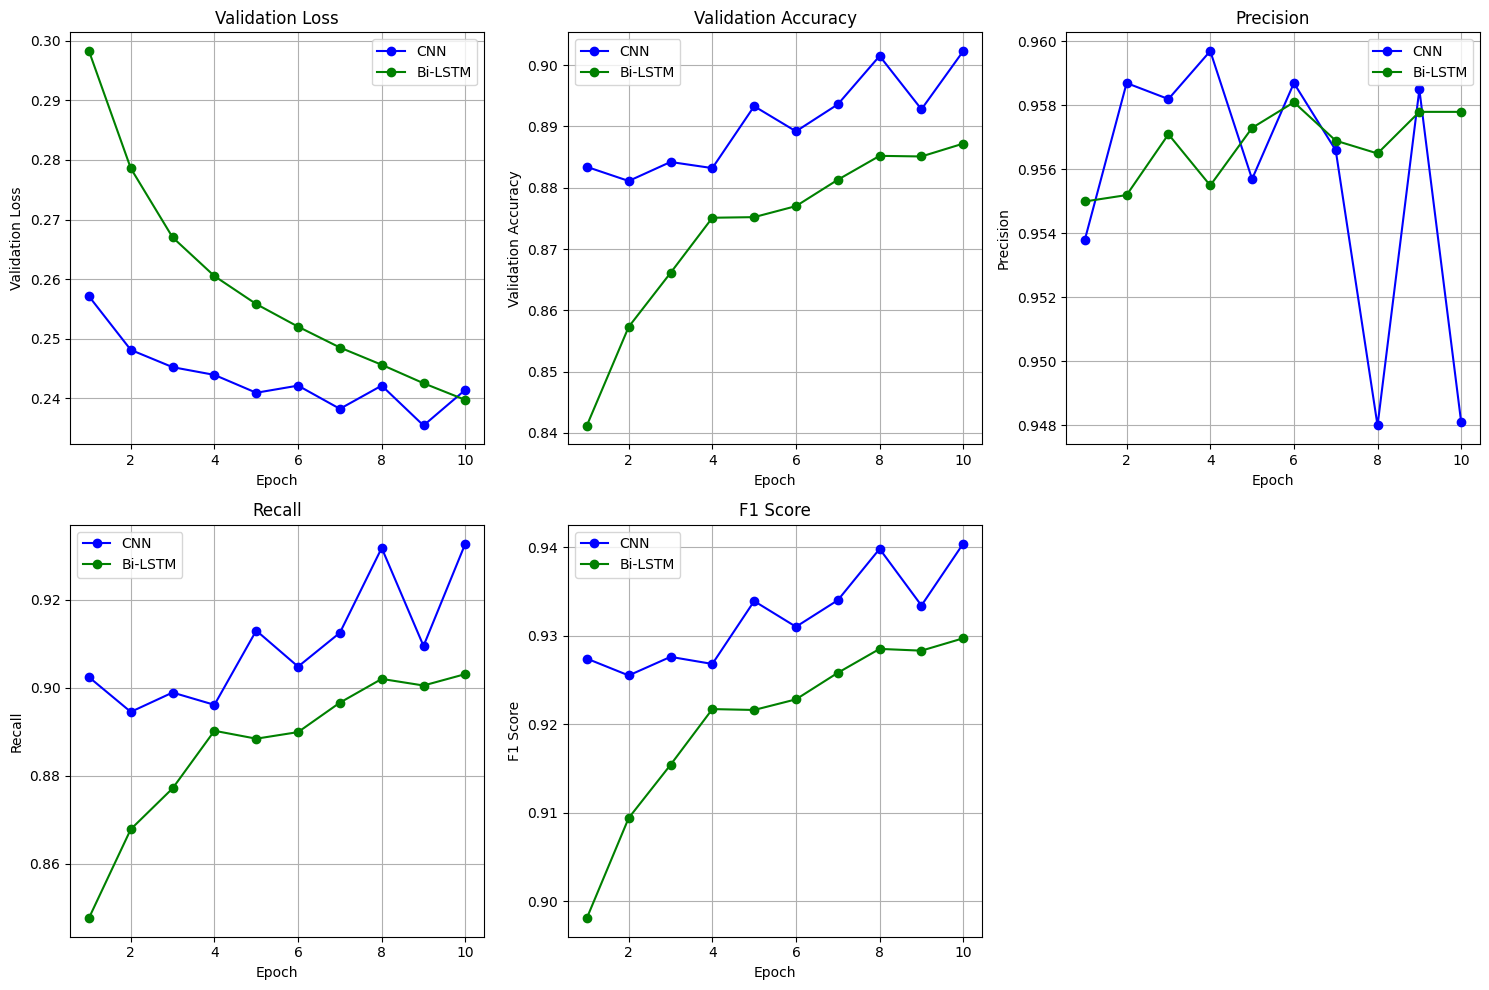

In [32]:
# This is plot_baseline.py
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# CNN log data
cnn_data = {
    "Validation Loss": [0.2571, 0.2481, 0.2452, 0.2439, 0.2409, 0.2421, 0.2382, 0.2421, 0.2354, 0.2414],
    "Validation Accuracy": [0.8834, 0.8811, 0.8842, 0.8832, 0.8933, 0.8892, 0.8936, 0.9015, 0.8928, 0.9023],
    "Precision": [0.9538, 0.9587, 0.9582, 0.9597, 0.9557, 0.9587, 0.9566, 0.9480, 0.9585, 0.9481],
    "Recall": [0.9024, 0.8945, 0.8989, 0.8961, 0.9130, 0.9048, 0.9125, 0.9318, 0.9095, 0.9328],
    "F1 Score": [0.9274, 0.9255, 0.9276, 0.9268, 0.9339, 0.9310, 0.9340, 0.9398, 0.9334, 0.9404]
}

# Bi-LSTM log data
bilstm_data = {
    "Validation Loss": [0.2983, 0.2786, 0.2670, 0.2605, 0.2558, 0.2520, 0.2485, 0.2456, 0.2425, 0.2397],
    "Validation Accuracy": [0.8412, 0.8573, 0.8661, 0.8751, 0.8752, 0.8770, 0.8813, 0.8852, 0.8851, 0.8872],
    "Precision": [0.9550, 0.9552, 0.9571, 0.9555, 0.9573, 0.9581, 0.9569, 0.9565, 0.9578, 0.9578],
    "Recall": [0.8476, 0.8678, 0.8771, 0.8902, 0.8884, 0.8899, 0.8966, 0.9020, 0.9005, 0.9031],
    "F1 Score": [0.8981, 0.9094, 0.9154, 0.9217, 0.9216, 0.9228, 0.9258, 0.9285, 0.9283, 0.9297]
}

metrics = ["Validation Loss", "Validation Accuracy", "Precision", "Recall", "F1 Score"]
colors = ['blue', 'green']
labels = ['CNN', 'Bi-LSTM']

# Rearrange the subplots to be in a 2x3 grid with the last subplot occupying two columns
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Plotting the same data with the new layout
for i, metric in enumerate(metrics):
    axs[i].plot(epochs, cnn_data[metric], marker='o', color=colors[0], label=labels[0])
    axs[i].plot(epochs, bilstm_data[metric], marker='o', color=colors[1], label=labels[1])
    axs[i].set_title(metric)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel(metric)
    axs[i].legend()
    axs[i].grid(True)

# Hide the last subplot (the 6th subplot) as we only have 5 metrics
fig.delaxes(axs[-1])


plt.tight_layout()
plt.show()

## Plotting the Results of all the Models in CV = 7:3 Experiment

In [ ]:
# This is Plot.py
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve


def plot_model_comparisons(results, metric_names, model_names):
    epochs = results.shape[2]
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Adjust for five validation metrics

    for i, ax in enumerate(axes.flatten()):
        if i >= len(metric_names):  # We have more subplots than metrics
            ax.axis('off')  # Hide unused subplot
            continue
        for j in range(results.shape[0]):
            ax.plot(range(epochs), results[j, i, :], label=f"{model_names[j]}")
        ax.set_title(metric_names[i])
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric_names[i])
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_model_comparisons_bar(results, metric_names, model_names):
    # model_names = ["RNN", "LSTM", "BiLSTM"]
    # model_names = ["NCP", "BiNCP", "RNN", "LSTM", "BiLSTM"]
    epochs = results.shape[2]
    num_metrics = len(metric_names)
    num_models = len(model_names)

    fig, axes = plt.subplots(nrows=num_metrics, figsize=(10, 2 * num_metrics), sharex=True)
    bar_width = 0.15  # Reduce the bar width to prevent overlap
    index = np.arange(epochs)

    for metric_idx, ax in enumerate(axes):
        min_val = np.min(results[:, metric_idx, :])  # Find the minimum value for this metric
        max_val = np.max(results[:, metric_idx, :])  # Find the maximum value for this metric
        range_val = max_val - min_val
        margin = 0.1 * range_val  # 10% margin on each side

        for model_idx, model_name in enumerate(model_names):
            metric_data = results[model_idx, metric_idx, :]
            pos = index + model_idx * (bar_width + 0.05)  # Adjust position to add space between bars
            ax.bar(pos, metric_data, bar_width, label=model_name, alpha=0.7)

        ax.set_ylim(min_val - margin, max_val + margin)  # Set y-axis limits with margin
        ax.set_ylabel(metric_names[metric_idx])
        ax.set_title(f'Epoch Comparison for {metric_names[metric_idx]}')
        ax.set_xticks(index + bar_width / 2 * (num_models - 1))
        ax.set_xticklabels([f'Epoch {i+1}' for i in range(epochs)])
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_best_comparisons_bar(results, metric_names, model_names):
    num_metrics = len(metric_names)
    num_models = len(model_names)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown',
              'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    fig, axes = plt.subplots(nrows=num_metrics, figsize=(3, 10), sharex=True) 

    # set the bar width
    bar_width = 1 

    for metric_idx, ax in enumerate(axes):
        max_vals = np.zeros(num_models)


        for model_idx in range(num_models):
            max_vals[model_idx] = np.max(results[model_idx, metric_idx, :])

        x_pos = np.arange(num_models)
        bars = ax.bar(x_pos, max_vals, bar_width, alpha=0.7)

        # set different color for each bar
        for bar, color in zip(bars, colors):
            bar.set_color(color)
            # print results
            height = bar.get_height()
            # print the height of the bar
            print(f'{metric_names[metric_idx]} - {model_names[int(bar.get_x() + bar.get_width() / 2.0)]}: {height:.10f}')

        ax.set_ylabel(metric_names[metric_idx])
        ax.set_title(f'Maximum {metric_names[metric_idx]} Across All Epochs')
        ax.set_xticks(x_pos)
        ax.set_xticklabels(model_names)
        # move legend outside of the plot`
        ax.legend(bars, model_names, title="Model", loc="center left", bbox_to_anchor=(1, 0.5))
        # set y-axis limit
        # ax.set_ylim([0.985, 1])
        # find the min value on the y-axis
        min_val = np.min(max_vals)
        # find the max value on the y-axis
        max_val = np.max(max_vals)
        # set the y-axis limit with margin
        ax.set_ylim(min_val - 0.1 * (max_val - min_val), max_val + 0.1 * (max_val - min_val))
        # empty the x-axis label
        ax.set_xlabel('')



    plt.tight_layout()
    plt.show()


def plot_roc_from_saved_data(filename):
    epoch_labels_outputs = np.load(filename, allow_pickle=True)

    plt.figure()
    for idx, (labels, outputs) in enumerate(epoch_labels_outputs):
        labels = labels.ravel()
        outputs = outputs.ravel()
        print(labels.shape, outputs.shape)
        fpr, tpr, thresholds = roc_curve(labels, outputs)
        plt.plot(fpr, tpr, label=f'Model {idx + 1}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic")
    plt.legend(loc="lower right")
    plt.show()


if __name__ == '__main__':

    # load the results
    # results_cv_hid_64.npy
    results = np.load('results_cv_hid_32.npy')

    print(results.shape)

    # remove result's to (2, 6, 10)
    print(results.shape)
    model_names = ["S2S_LSTM", "S2S_BiLSTM", "NCP", "BiNCP", "BiLSTM", "RNN", "LSTM"]
    # model_names = ["S2S_LSTM", "S2S_BiLSTM", "BiLSTM", "RNN", "LSTM"]
    # model_names = ["NCP", "BiNCP", "RNN", "LSTM", "BiLSTM"]
    # model_names = ["NCP", "BiNCP", "BiLSTM"]

    # Plot the model comparisons for validation metrics
    metric_names = ["Accuracy", "Precision", "Recall", "F1 Score"]
    plot_model_comparisons(results[:, 1:, 2:], metric_names, model_names)
    plot_model_comparisons_bar(results[:, 1:, 2:], metric_names, model_names)  # Skip train_losses for plotting
    plot_best_comparisons_bar(results[:, 2:, 1:], metric_names, model_names)  # Skip train_losses for plotting


## Plotting the Results of all the Models in K-Fold Cross Validation

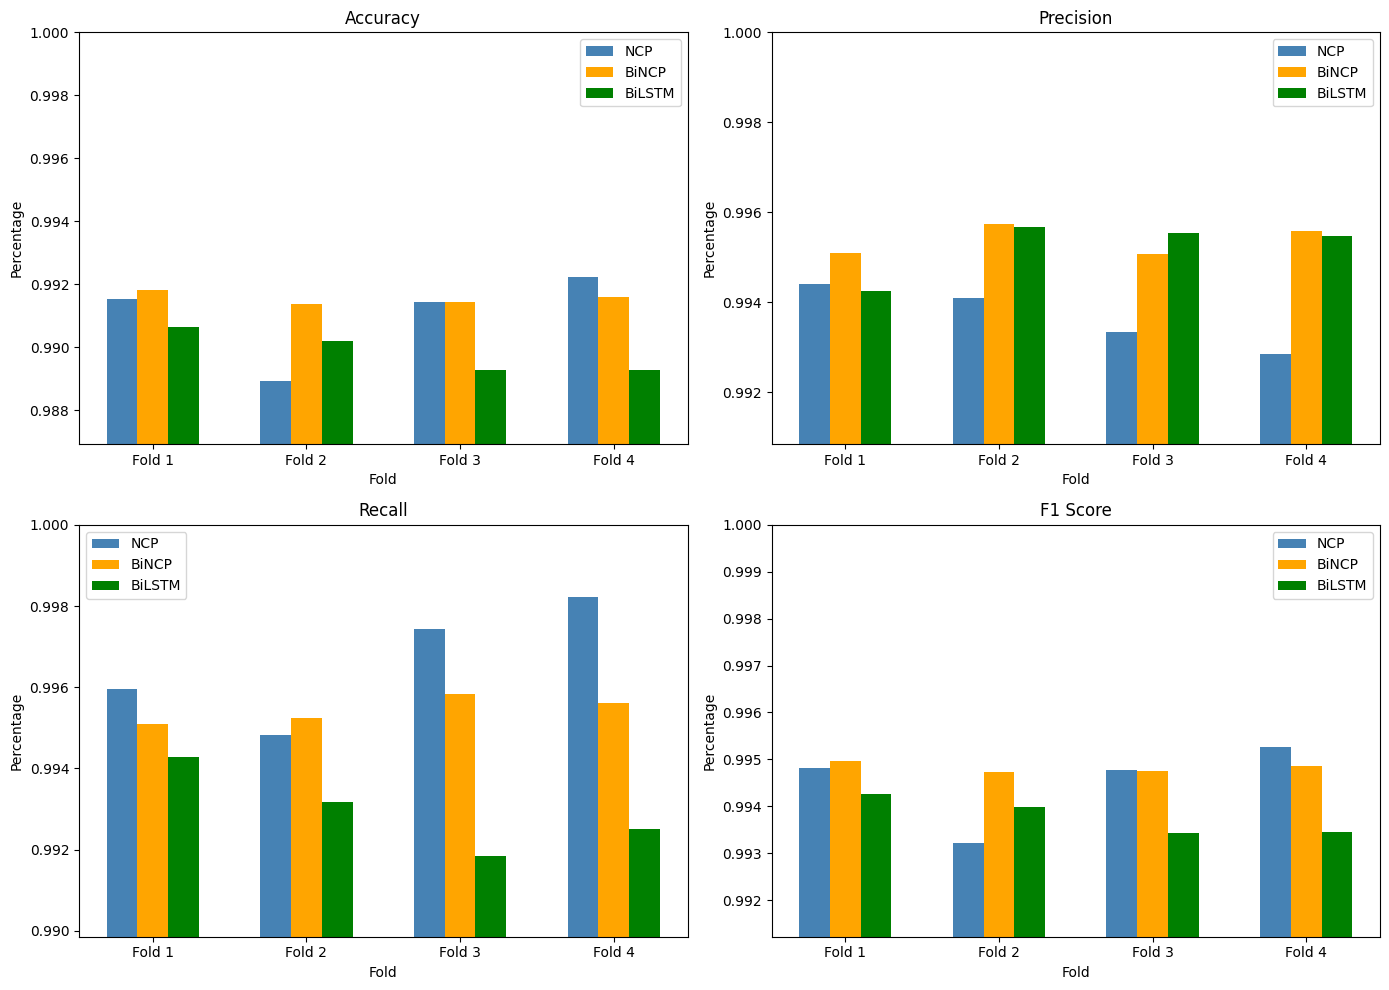

In [34]:
# This is k-fold-plot.py

# Data for the 4 folds
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4']

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
models = ['NCP', 'BiNCP', 'BiLSTM']

# Data for each fold
data = {
    'Accuracy': {
        'NCP': [0.9915510240, 0.9889299012, 0.9914345368, 0.9922245322],
        'BiNCP': [0.9918158114, 0.9913917204, 0.9914426419, 0.9916019786],
        'BiLSTM': [0.9906597887, 0.9901947781, 0.9892915500, 0.9892988531]
    },
    'Precision': {
        'NCP': [0.9944140182, 0.9941024944, 0.9933405095, 0.9928499813],
        'BiNCP': [0.9950945818, 0.9957444023, 0.9950805747, 0.9955914478],
        'BiLSTM': [0.9942586274, 0.9956660897, 0.9955523807, 0.9954669875]
    },
    'Recall': {
        'NCP': [0.9959556068, 0.9948354735, 0.9974250718, 0.9982253648],
        'BiNCP': [0.9950991471, 0.9952511694, 0.9958336231, 0.9956216454],
        'BiLSTM': [0.9942724256, 0.9931687310, 0.9918559948, 0.9925066573]
    },
    'F1 Score': {
        'NCP': [0.9948185913, 0.9932201241, 0.9947648025, 0.9952558038],
        'BiNCP': [0.9949758605, 0.9947352697, 0.9947614157, 0.9948645725],
        'BiLSTM': [0.9942655264, 0.9939919404, 0.9934234760, 0.9934445892]
    }
}

colors = {
    'NCP': 'steelblue',
    'BiNCP': 'orange',
    'BiLSTM': 'green'
}

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, metric in enumerate(metrics):
    ax = axs[i]
    x = np.arange(len(folds))
    width = 0.2

    # Find the minimum value for this metric to adjust the y-axis starting point
    all_values = np.concatenate([data[metric][model] for model in models])
    y_min = min(all_values) - 0.002  # Start y-axis a bit below the minimum value

    ax.bar(x - width, data[metric]['NCP'], width, label='NCP', color=colors['NCP'])
    ax.bar(x, data[metric]['BiNCP'], width, label='BiNCP', color=colors['BiNCP'])
    ax.bar(x + width, data[metric]['BiLSTM'], width, label='BiLSTM', color=colors['BiLSTM'])

    ax.set_xlabel('Fold')
    ax.set_ylabel('Percentage')
    ax.set_title(metric)
    ax.set_xticks(x)
    ax.set_xticklabels(folds)
    ax.set_ylim([y_min, 1.0])  # Set y-axis limits to make differences more visible
    ax.legend()


plt.tight_layout()
plt.show()
